In [ ]:
!pip uninstall pyarrow
!pip install pyarrow

In [3]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
import os

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Data preparation

In [10]:
df = pd.read_csv(base_dir + csv_path)

df.head()

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [14]:
train_df['label'] = train_df['filename'].apply(lambda x: 'benign' if 'benign' in x.lower() else 'malignant')
test_df['label']  = test_df['filename'].apply(lambda x: 'benign' if 'benign' in x.lower() else 'malignant')

In [18]:
train_df["filepath"][0]

'C:/Users/taona/Documents/my work/Breast Cancer Histopathology Image Classification/data/raw/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png'

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # Reduced rotation
    width_shift_range=0.1,  # Reduced shift
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [58]:
train_gen = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepath',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

Found 5005 validated image filenames belonging to 2 classes.


### Building the Deep learning model

In [66]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(244, 244, 3)
)

# Freeze all ResNet layers
base_model.trainable = False

model = Sequential([
    Input(shape=(244, 244, 3)),
    base_model,
    
    GlobalAveragePooling2D(),  # Replace multiple Conv2D with GlobalAveragePooling
    
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

In [70]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,859,073 (91.02 MB)

 Trainable params: 270,977 (1.03 MB)

 Non-trainable params: 23,588,096 (89.98 MB)

In [72]:
logdir = 'logs'

In [51]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

hist = model.fit(
    train_gen,
    epochs=15,  
    steps_per_epoch=len(train_gen),
    validation_data=test_gen,
    validation_steps=len(test_gen),
    callbacks=[tensorboard_callback, early_stopping]
)

C:\Users\taona\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - accuracy: 0.5719 - loss: 2.2201 - val_accuracy: 0.6529 - val_loss: 1.8377
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 445s 1s/step - accuracy: 0.6926 - loss: 1.0504 - val_accuracy: 0.3471 - val_loss: 2.9872
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.7168 - loss: 0.8407 - val_accuracy: 0.6615 - val_loss: 1.4000
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.7349 - loss: 0.7207 - val_accuracy: 0.5038 - val_loss: 0.9104
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.7246 - loss: 0.6775 - val_accuracy: 0.3891 - val_loss: 1.1313
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.7500 - loss: 0.6419 - val_accuracy: 0.3716 - val_loss: 1.3277
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.7452 - loss: 0.6198 - val_accuracy: 0.6529 - val_loss: 1.9554
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - accuracy: 0.7502 - loss: 0.5956 - val_accu

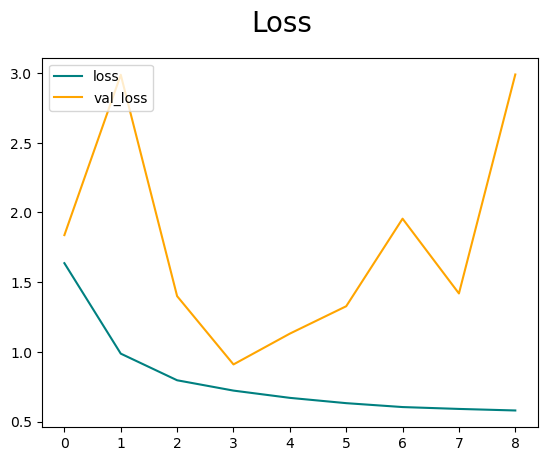

In [53]:
fig = plt.figure()
plt.plot(hist.history['loss'], color="teal", label='loss')
plt.plot(hist.history['val_loss'], color="orange", label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

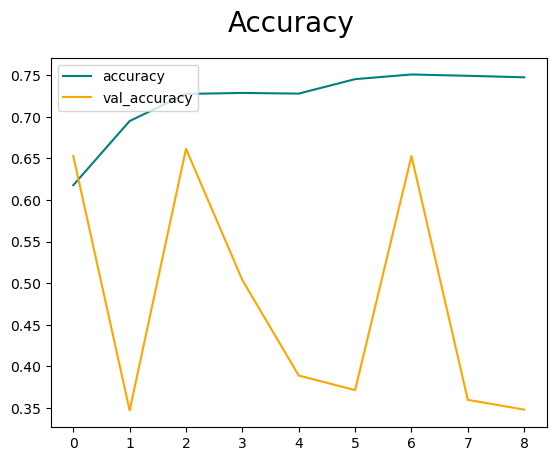

In [55]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color="teal", label='accuracy')
plt.plot(hist.history['val_accuracy'], color="orange", label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluation

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test_df.as_numpy_iterator():
     x, y = batch
     yhat = model.predict(x)
     pre.update_state(y, yhat)
     re.update_state(y, yhat)
     acc.update_state(y, yhat)

In [ ]:
print(f"Precision: {pre.result().numpy()}, Recall: {re.result(),numpy()}, Accuracy: {acc.result().numpy()}")

In [ ]:
import cv2

In [ ]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(reize.numpy().astype(int))
plt.show()

In [ ]:
yhat


# Saving the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models', 'Breast_Cancer_Histopathology_Image_Classification_model.keras'))

In [ ]:
new_model = load_model(os.path.join('models', 'Breast_Cancer_Histopathology_Image_Classification_model.keras'))

In [ ]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

In [ ]:
if yhatnew > 0.5:
    print("Predicted class is benign")
else:
    print("Predicted class is malignant")